In [1]:
import os 
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ann
import diffxpy.api as de

from matplotlib import rcParams
from matplotlib import colors

sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.3.10 numpy==1.19.2 scipy==1.5.2 pandas==1.1.2 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.7.0


In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 35)

In [3]:
adata = sc.read('./../../data/processed/adata_annotated.h5ad')
adata_ = sc.read('./../../data/processed/data_norm.h5ad')
adata_.obs = adata.obs.copy()

In [4]:
#Load saved diffxpy results
import pickle 
with open('../../results/diffxpy_louvain_correct_noconstraints_2021.pickle', 'rb') as f:
    de_results_louvain = pickle.load(f)

# Look at the results

In [5]:
de_results_listofdicts = []
for i, item in enumerate(de_results_louvain):
    de_results_dict = {
        'louvain': de_results_louvain[i]    
    }
    if i == 0:
        de_results_dict['pairtest'] = 'BL Ctrl vs BL Stress'
    elif i == 1:
        de_results_dict['pairtest'] = 'ELS Ctrl vs ELS Stress'
    elif i == 2:
        de_results_dict['pairtest'] = 'BL Stress vs ELS Stress'
    elif i == 3:
        de_results_dict['pairtest'] = 'BL Ctrl vs ELS Ctrl'
    de_results_listofdicts.append(de_results_dict)

In [6]:
def de_postprocessing(de_results_listofdicts, adata):
    de_post = []
    
    for de_results_dict in de_results_listofdicts:
        for clust_type in ['louvain']:
            for clust in de_results_dict[clust_type]:
                if clust in adata.obs[clust_type].cat.categories:
                    tmp = de_results_dict[clust_type][clust].summary()
                    n_infll = np.sum(tmp['ll'] == np.float64('-inf'))
                    tmp = tmp.loc[tmp['ll'] != np.float64('-inf')]
    
                    #Sort values by q-value
                    tmp.sort_values(by='qval', ascending=True, inplace=True)
        
                    de_post.append({'clust': clust, 
                              'clust_type': clust_type, 
                              'de_post': tmp.copy(), 
                              'de_raw': de_results_dict[clust_type][clust],
                              'pairtest': de_results_dict['pairtest']
                             })
            
    de_post_df = pd.DataFrame(de_post)
    del de_post
    
    de_post_df['ndeg_mean0.5'] = ''
    de_post_df['ndeg_mean1'] = ''
    de_post_df['ndeg'] = ''
    
    for index, row in de_post_df.T.iteritems():
        test = row['pairtest']
        if test == 'BL Ctrl vs BL Stress':
            mask = ((adata.obs['baseline']=='BL'))
            condition_key = 'adult_stress'
            condition_ctrl = 'Ctrl'
            condition_test = 'Stress'
        elif test == 'ELS Ctrl vs ELS Stress':
            mask = ((adata.obs['baseline'] == 'ELS'))
            condition_key = 'adult_stress'
            condition_ctrl = 'Ctrl'
            condition_test = 'Stress'
        elif test == 'BL Ctrl vs ELS Ctrl':
            mask = ((adata.obs['adult_stress'] == 'Ctrl'))
            condition_key = 'baseline'
            condition_ctrl = 'BL'
            condition_test = 'ELS'
        elif test == 'BL Stress vs ELS Stress':
            mask = ((adata.obs['adult_stress'] == 'Stress'))
            condition_key = 'baseline'
            condition_ctrl = 'BL'
            condition_test = 'ELS'

        adata_test = adata_[mask]
        expr_dict_stress = {}
        expr_dict_ctrl = {}
        clust = row['clust']
        
        expr_ctrl = np.mean(adata_test[
            (adata_test.obs[condition_key]==condition_ctrl) 
            & (adata_test.obs['louvain'] == clust)
        ].X, axis=0)
        
        expr_stress = np.mean(adata_test[
            (adata_test.obs[condition_key]==condition_test) 
            & (adata_test.obs['louvain'] == clust)
        ].X, axis=0)
        
        for i, gene in enumerate(adata_test.var.index):
            expr_dict_stress[gene] = expr_stress[i]
            expr_dict_ctrl[gene] = expr_ctrl[i]

        de_post_df.iloc[index]['de_post']['mean_ctrl'] = [
            expr_dict_ctrl[gene] for gene in row['de_post']['gene'].values
        ]
        
        de_post_df.iloc[index]['de_post']['mean_test'] = [
            expr_dict_stress[gene] for gene in row['de_post']['gene'].values
        ]

        de_post_df.iloc[index]['ndeg_mean0.5'] = (
            de_post_df
            .iloc[index]['de_post']
            .loc[
                (row['de_post']['qval']<0.05)
                & (
                    (row['de_post']['mean_test']>0.5)
                    | (row['de_post']['mean_ctrl']>0.5)
                )
            ]
            .shape[0]
        )
        
        de_post_df.iloc[index]['ndeg_mean1'] = (
            de_post_df
            .iloc[index]['de_post']
            .loc[
                (row['de_post']['qval']<0.05) 
                & (
                    (row['de_post']['mean_test']>1)
                    | (row['de_post']['mean_ctrl']>1)
                )
            ]
            .shape[0]
        )
        
        de_post_df.iloc[index]['ndeg'] = (
            de_post_df
            .iloc[index]['de_post']
            .loc[(row['de_post']['qval']<0.05)]
            .shape[0]
        )

    return de_post_df

In [7]:
de_post_df = de_postprocessing(de_results_listofdicts, adata)

/app/python37/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python37/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python37/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python37/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python37/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarni

BL Ctrl vs BL Stress
ELS Ctrl vs ELS Stress
BL Stress vs ELS Stress
BL Ctrl vs ELS Ctrl


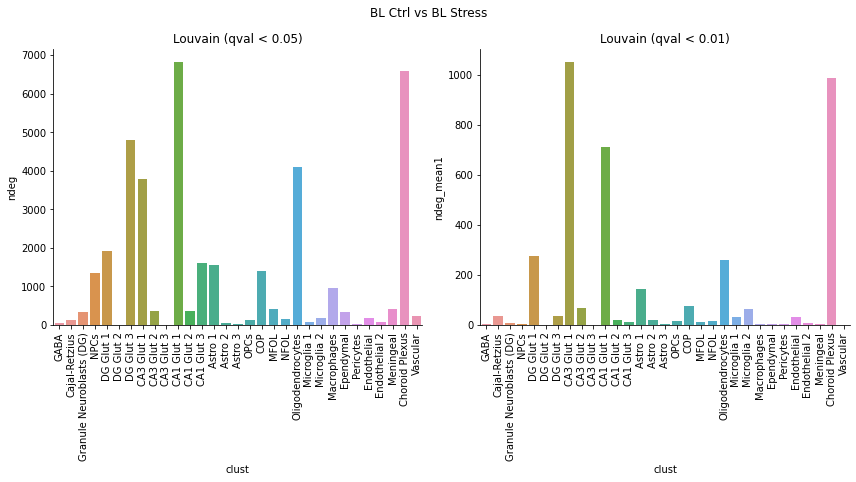

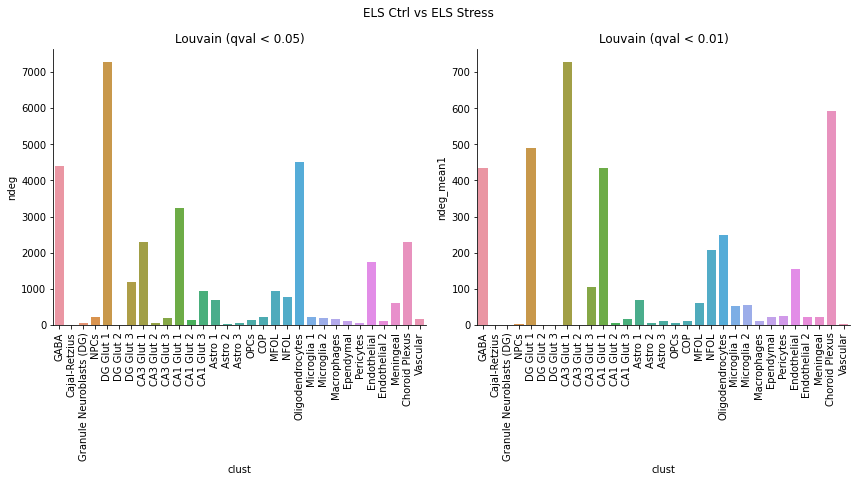

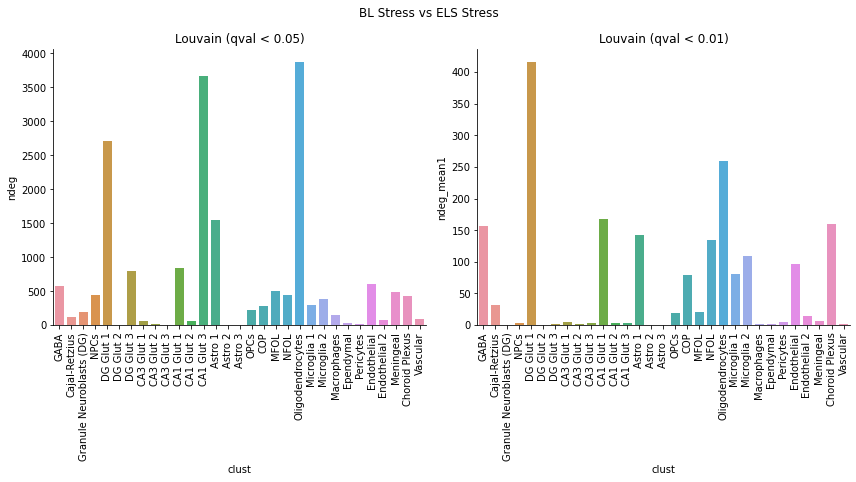

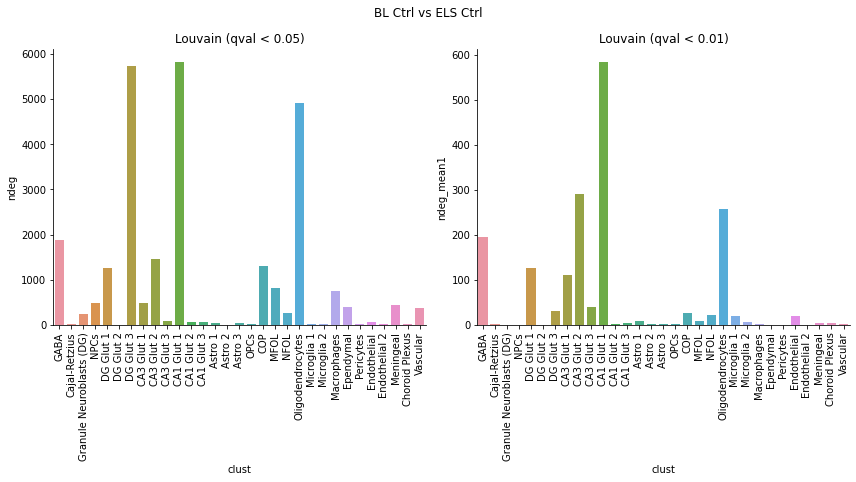

In [8]:
for pairtest in de_post_df['pairtest'].unique():
    print(pairtest)
    fig, ax = plt.subplots(1, 2, figsize=(12, 7), sharey=False)
    
    tmp_df = de_post_df[de_post_df['pairtest']== pairtest]

    tmp_df_louvain = tmp_df[tmp_df['clust_type']=='louvain']
    sns.barplot(x='clust', y='ndeg', data=tmp_df_louvain, ax=ax[0])
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
    ax[0].set_title('Louvain (qval < 0.05)')

    sns.barplot(x='clust', y='ndeg_mean1', data=tmp_df_louvain, ax=ax[1])
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    ax[1].set_title('Louvain (qval < 0.01)')
    sns.despine()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle(pairtest)
    fig.savefig('./figures/DE_' + pairtest.replace(' ', '_') + '.png', dpi=200)

0 BL Ctrl vs BL Stress
1 ELS Ctrl vs ELS Stress
2 BL Stress vs ELS Stress
3 BL Ctrl vs ELS Ctrl
0 BL Ctrl vs BL Stress
1 ELS Ctrl vs ELS Stress


/app/python37/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


2 BL Stress vs ELS Stress
3 BL Ctrl vs ELS Ctrl
0 BL Ctrl vs BL Stress
1 ELS Ctrl vs ELS Stress
2 BL Stress vs ELS Stress
3 BL Ctrl vs ELS Ctrl
0 BL Ctrl vs BL Stress
1 ELS Ctrl vs ELS Stress


/app/python37/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


2 BL Stress vs ELS Stress
3 BL Ctrl vs ELS Ctrl


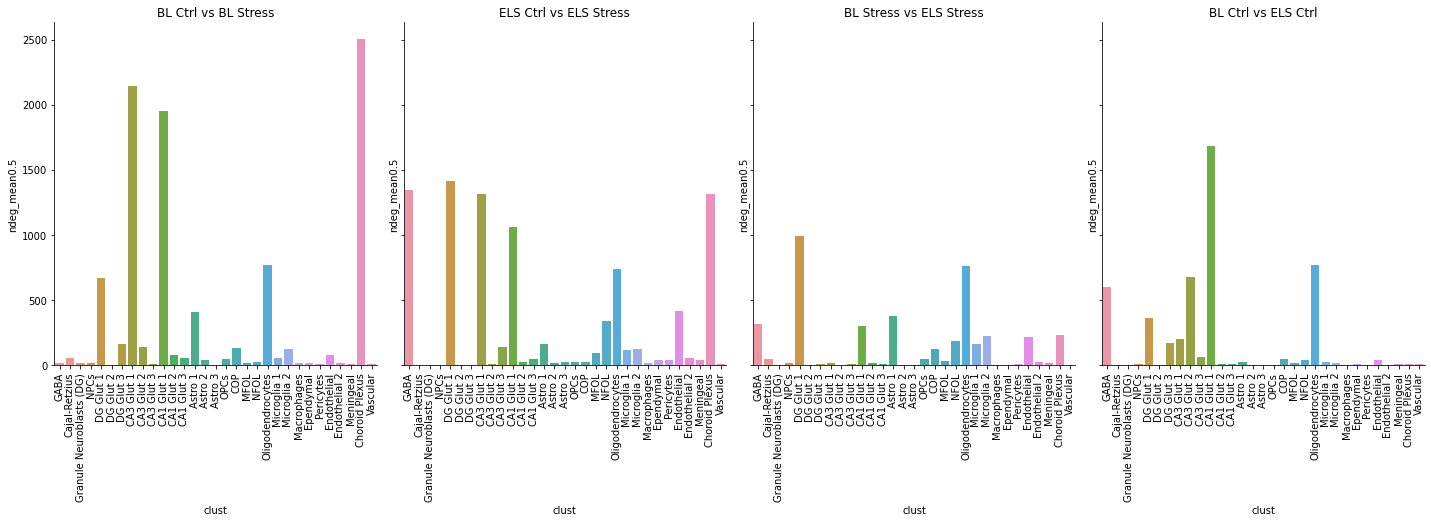

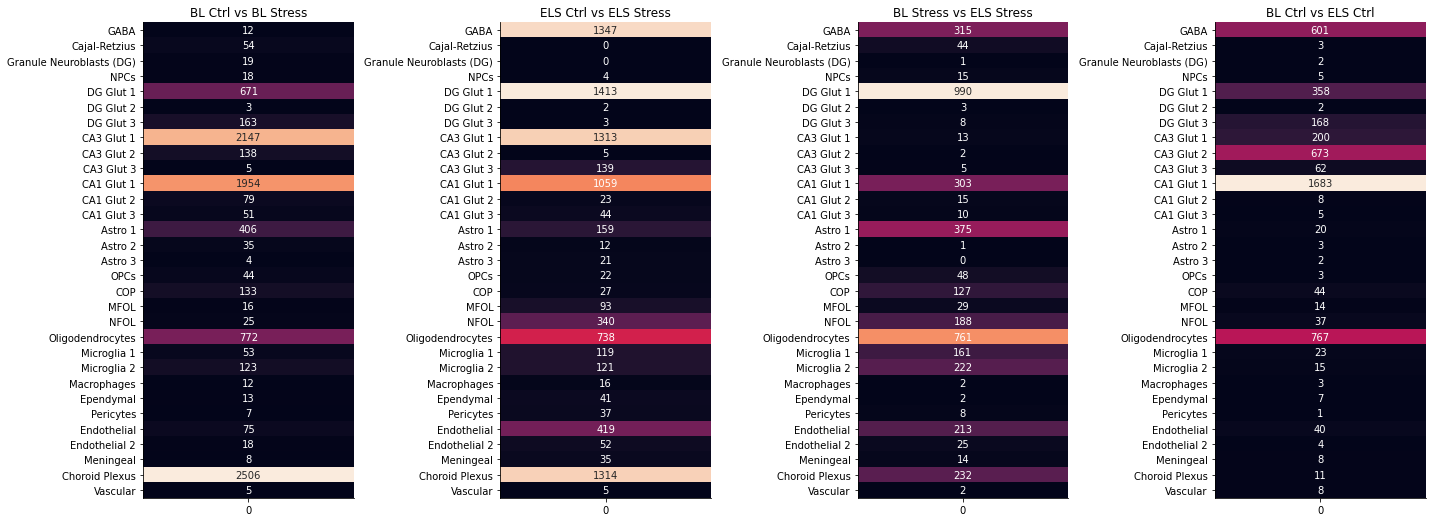

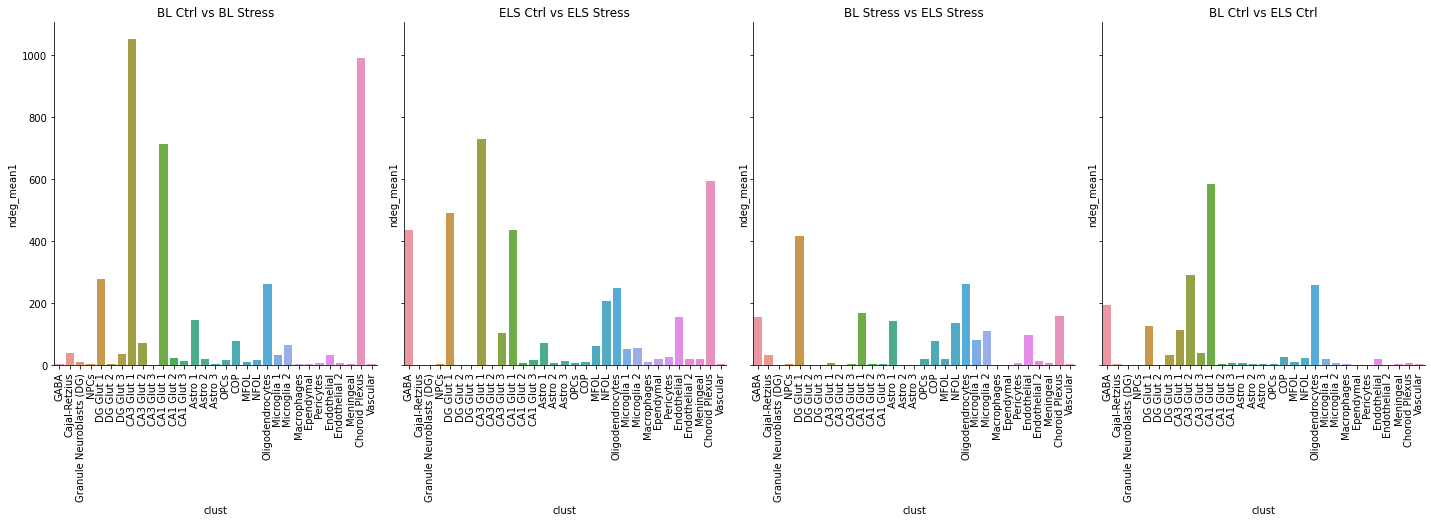

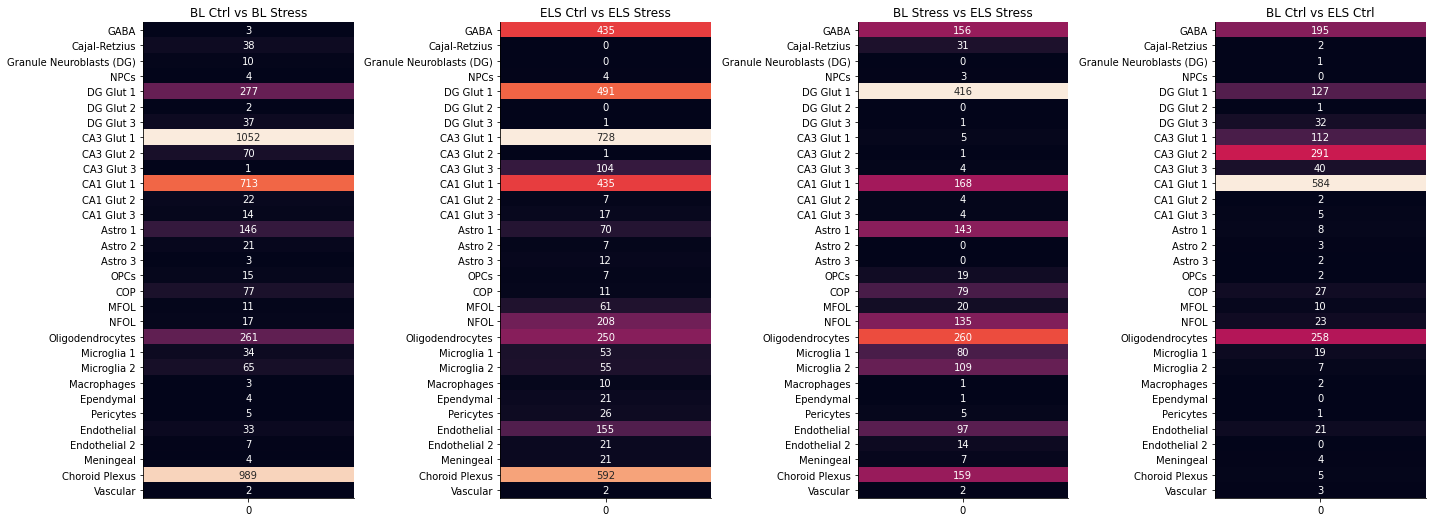

In [9]:
fig, ax = plt.subplots(1, len(de_post_df['pairtest'].unique()), figsize=(5*len(de_post_df['pairtest'].unique()), 8), sharey=True)
for i, test in enumerate(de_post_df['pairtest'].unique()):
    print(i, test)
    tmp_df = de_post_df[de_post_df['pairtest']== test]

    tmp_df_louvain = tmp_df[tmp_df['clust_type']=='louvain']
    sns.barplot(x='clust', y='ndeg_mean0.5', data=tmp_df_louvain, ax=ax[i])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    ax[i].set_title(test)
    
sns.despine()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('../../figures/DE_thresh0.5_nc.png', dpi=200)

fig, ax = plt.subplots(1, len(de_post_df['pairtest'].unique()), figsize=(5*len(de_post_df['pairtest'].unique()), 8), sharey=False)
for i, test in enumerate(de_post_df['pairtest'].unique()):
    print(i, test)
    tmp_df = de_post_df[de_post_df['pairtest']== test]  
    sns.heatmap(tmp_df['ndeg_mean0.5'][:, np.newaxis].astype(int), annot=True, fmt='d',
                yticklabels=tmp_df['clust'], ax=ax[i], cbar=False)
    ax[i].set_title(test)
sns.despine()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('../../figures/DE_thresh0.5_table_nc.png', dpi=200)

fig, ax = plt.subplots(1, len(de_post_df['pairtest'].unique()), figsize=(5*len(de_post_df['pairtest'].unique()), 8), sharey=True)
for i, test in enumerate(de_post_df['pairtest'].unique()):
    print(i, test)
    tmp_df = de_post_df[de_post_df['pairtest']== test]

    tmp_df_louvain = tmp_df[tmp_df['clust_type']=='louvain']
    sns.barplot(x='clust', y='ndeg_mean1', data=tmp_df_louvain, ax=ax[i])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    ax[i].set_title(test)
    
sns.despine()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('../../figures/DE_thresh1_nc.png', dpi=200)

fig, ax = plt.subplots(1, len(de_post_df['pairtest'].unique()), figsize=(5*len(de_post_df['pairtest'].unique()), 8), sharey=False)
for i, test in enumerate(de_post_df['pairtest'].unique()):
    print(i, test)
    tmp_df = de_post_df[de_post_df['pairtest']== test]  
    sns.heatmap(tmp_df['ndeg_mean1'][:, np.newaxis].astype(int), annot=True, fmt='d',
                yticklabels=tmp_df['clust'], ax=ax[i], cbar=False)
    ax[i].set_title(test)
sns.despine()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('../../figures/DE_thresh1_table_nc.png', dpi=200)

In [10]:
for test in ['BL Ctrl vs BL Stress', 'ELS Ctrl vs ELS Stress', 'BL Ctrl vs ELS Ctrl', 'BL Stress vs ELS Stress']:
    de_test = de_post_df[de_post_df['pairtest']==test]
    clusters = de_test['clust'].unique()

    result = {row['clust']:row['de_post'] for i, row in de_test.T.iteritems()}

    writer = pd.ExcelWriter('../../results/de_' + test.lower().replace(' ', '') + '_thresh_noconstraints.xlsx', engine='xlsxwriter')
    print(test)
    for clust in clusters:
        res_clust = result[clust]
        res_clust = res_clust[(res_clust['mean_test'] > 0.5) | (res_clust['mean_ctrl'] > 0.5)]
        res_clust.to_excel(writer,sheet_name=str(clust))
    writer.save()


BL Ctrl vs BL Stress
ELS Ctrl vs ELS Stress
BL Ctrl vs ELS Ctrl
BL Stress vs ELS Stress


In [11]:
for test in ['BL Ctrl vs BL Stress', 'ELS Ctrl vs ELS Stress', 'BL Ctrl vs ELS Ctrl', 'BL Stress vs ELS Stress']:
    de_test = de_post_df[de_post_df['pairtest']==test]
    clusters = de_test['clust'].unique()

    result = {row['clust']:row['de_post'] for i, row in de_test.T.iteritems()}

    writer = pd.ExcelWriter('../../results/de_' + test.lower().replace(' ', '') + '_thresh_noconstraints_unfiltered.xlsx', engine='xlsxwriter')
    print(test)
    for clust in clusters:
        res_clust = result[clust]
        res_clust.to_excel(writer,sheet_name=str(clust))
    writer.save()


BL Ctrl vs BL Stress
ELS Ctrl vs ELS Stress
BL Ctrl vs ELS Ctrl
BL Stress vs ELS Stress
